Prototype of model explanation via LIME with help of extractive summary
---

---

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import time

tfds.disable_progress_bar()

In [4]:
now = time.strftime("%Y-%m-%d_%H:%M")

In [5]:
import logging
import sys

logging.basicConfig(
    level=logging.DEBUG, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(filename=f'../../data/logs/v3-fixed-{now}.log'),
#         logging.StreamHandler(sys.stdout)
    ]
)

l = logging.getLogger('prototype')
l.critical("Logging LIME with new TF model")

---

Model-related
---

In [2]:
def load_model():
    """
    Define a function that loads a model to be explained and returns its instance
    """
    
    return keras.models.load_model("../../raw-data/lstm-model-sigmoid")    

In [6]:
model = load_model()
l.info("Model loaded")

In [ ]:
model.predict(["hahahahahahahahahaha this is the most boring film I have ever seen"])

In [ ]:
model.predict_proba(["hahahahahahahahahaha this is the funniest film I have ever seen"])
# Even though model has function `predict_proba`, it is not sufficient for LIME
# LIME expects this predict_proba function to return probability for each of the predicted classes

---

Explanation
---

#### 1. Preparation

In [7]:
from lime import lime_text

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.text_rank import TextRankSummarizer

import os

from functools import reduce

In [8]:
INPUT_DIR = "/home/tomasmizera/school/diploma/src/data/reviews"

LANGUAGE = "english"
SENTENCES_COUNT = 6
TOP_FEATURES_COUNT = 100

EXPL_IX = 1
SUMMARY_IX = 0
CLASSES = ['Positive', 'Negative'] # NOTE: Order matters!

MINIMAL_WORD_WEIGHT = 0.001
HP_FACTOR = 0

In [9]:
summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
summarizer.stop_words = get_stop_words(LANGUAGE)

In [28]:
explanator = lime_text.LimeTextExplainer(class_names=CLASSES)

---

### 2. Execution

In [8]:
l.info("Starting an algorithm")

In [ ]:
# define a decorator to log execusion time
# inspired by https://medium.com/pythonhive/python-decorator-to-measure-the-execution-time-of-methods-fa04cb6bb36d

def timeit(method):
    def timed(*args, **kw):
        timed.calls += 1
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        timed.time_taken += (te - ts) * 1000
        return result
    timed.calls = 0
    timed.time_taken = 0
    return timed

In [11]:
# @timeit # for LIME it is called once and for this model takes around 150ms with logging
def _predict_proba(_input):
    """
    Define a function that accepts array of instances and returns a probability for each class 
    _input - 1d array of instances
    Returns 2d array of [num of instances] x [num of classes] with probabilities
    """
    prediction = model.predict( _input )
    
    return np.append(prediction, 1 - prediction, axis=1)

In [12]:
def _explain_instance(_file, _explanator):
    return  _explanator.explain_instance(_file, _predict_proba, num_features=TOP_FEATURES_COUNT)

**Some examples of perturbed text**: \[ ..., ' great hm', ' great ', ' great hm', '  hm', '  ', '  hm', '  ', '  ', '  ', '  ', 'not great ', '  ', '  hm', '  ', '  ', 'not great ', '  ', ' great ', ' great ', '  hm', '  ', ' great ', 'not  hm', ' great hm', ' great ', ' great hm', '  hm', 'not  ', '  hm', 'not  ', ' great hm', 'not great ', ' great ', '  ', '  ', '  hm', '  ', '  ', '  ', 'not  hm', 'not  ', 'not great ', 'not  hm', 'not  hm', 'not great ', 'not  hm', '  ', ' great ', '  ', '  hm', 'not  hm', '  ', '  ', ' great ', '  ', '  ', ' great ', 'not  ', 'not  hm', ' great ', 'not  ', 'not  ', 'not  hm', 'not  ', '  ', 'not great ', '  hm', ' great hm', '  hm', '  ', '  ', 'not  hm', '  hm', 'not  ', '  ', ' great hm', 'not  ', ' great hm', 'not  hm', 'not  ', 'not  hm', '  ', ' great ', '  hm', ' great ', 'not  hm', 'not  ', 'not  ', ' great hm', 'not  hm', '  hm', '  hm', ' great ', '  ', 'not great ', '  hm', 'not great ', '  ', '  ', 'not  hm', 'not great ', '  ', '  ', ' great hm', 'not  hm', 'not  hm', ' great ', ' great hm', '  ', 'not  hm', ' great ', '  hm', ' great ', 'not great ', '  ', '  ', ' great hm', ' great hm', '  ', ' great ', 'not  hm', ' great ', 'not  ', ' great ', 'not great ', ' great ', 'not  ', 'not great ', '  ', '  ', '  ', 'not  ', ' great hm', ' great hm', '  ', '  ', 'not great ', '  ', '  ', 'not  ', ' great ', ' great ', 'not great ', '  ', '  ', '  ', '  ', '  ', '  ', '  hm', '  hm', 'not  ', 'not  hm', 'not  ', '  ', ' great ', '  hm', ' great hm', '  ', '  ', '  ', ' great hm', '  ', '  ', 'not  hm', '  ', ' great hm', ' great hm', ' great ', '  ', '  ', 'not  ', '  ', 'not  ', ' great hm', 'not great ', ' great hm', 'not  hm', 'not great ', 'not  ', 'not great ', '  ', 'not great ', '  hm', 'not  ', ' great ', '  ', '  ', ' great ', '  hm', 'not  ', 'not  ', 'not  ', '  ', ' great hm', ' great hm', ' great ', ' great ', 'not great ', ' great ', '  ', 'not great ', 'not great ', '  ', 'not  ', ' great ', ' great ', '  ', '  ', ' great ', 'not  ', ' great ', '  ', '  ', ' great ', 'not  hm', 'not  ', '  ', 'not great ', '  ', '  ', '  ', 'not great ', 'not great ', '  ', '  hm', '  hm', 'not  hm', 'not great ', ' great ', 'not  ', '  ', 'not  hm', 'not great ', 'not  ', 'not great ', 'not  hm', 'not  ', 'not  hm', ' great hm', ' great ', '  hm', '  ', '  hm', '  ', 'not  ', ' great ', '  ', '  hm', 'not  hm', 'not great ', '  ', '  ', ' great ', '  ', '  ', 'not  ', 'not  ', ' great ', '  ', 'not  hm', '  ', ' great hm', '  ', '  ', '  ', ' great ', ' great ', ' great ', ' great ', ' great ', '  hm', 'not  ', ' great ', 'not  hm', '  ', ' great hm', 'not great ', '  hm', '  hm', 'not  hm', 'not  ', 'not great ', '  ', '  ', '  ', 'not  ', '  ', ' great ', '  ', 'not great ', '  ', 'not  ', '  ', '  hm', ' great ', '  ', 'not  ', ' great hm', '  ', ' great ', 'not great ', '  ']

In [13]:
def input_from_files(path_to_files):
    """
    Loads all readable files in path_to_files directory
    Returns np.array with each files content as a separate element
    """
    
    def _read_text_file(filepath):
        with open(filepath, 'r') as f:
            return reduce(lambda a, b: a + b, f.readlines())
    
    files_it = os.scandir(path_to_files)
    files_contents = {}
    
    for file in files_it:
        if file.is_file(): 
            files_contents[file.name] = _read_text_file(file.path)
        
    return files_contents

In [14]:
npInput = input_from_files(INPUT_DIR)

In [30]:
# %%timeit
# explanator.explain_instance(npInput['review-med.txt'], _predict_proba, num_features=TOP_FEATURES_COUNT)
# explanator.explain_instance(npInput['review-top.txt'], _predict_proba, num_features=TOP_FEATURES_COUNT)
# explanator.explain_instance(npInput['review-low.txt'], _predict_proba, num_features=TOP_FEATURES_COUNT)

11.4 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
list(npInput.keys())

['review-low.txt-test-setup',
 'review-med.txt-test-setup',
 'review-med.txt-test',
 'review-low.txt',
 'review-top.txt-test',
 'review-med.txt',
 'review-top.txt',
 'review-low.txt-test',
 'review-top.txt-test-setup']

In [12]:
def _summarize_doc_custom(_summarizer, _instance, _explanation, factor):
    """
    Returns summary with altered weights based on explanation
    _summarizer - summy summarizer instance
    _instance - instance content string
    _explanation - LIME explanation
    """
    
    def _create_weight_graph(_summarizer, _instance_doc):
        return _summarizer.rate_sentences(_instance_doc)
    
    def _count_factor(_sentence, _explanation_words_weight, _factor_multiplier) -> float: # returns boosting factor for sentence
        f = 1.0
        exp_words = list(map(lambda x: x[0], _explanation_words_weight))
        for word in _sentence.words:
            if word in exp_words:
                f += _factor_multiplier * abs(_explanation_words_weight[exp_words.index(word)][1])
        return f
    
    parser = PlaintextParser.from_string(_instance, Tokenizer(LANGUAGE))
    graph = _create_weight_graph(_summarizer, parser.document)

    for sentence in graph.keys():
        fa_tme = _count_factor(sentence, _explanation.as_list(), factor)
        graph[sentence] = graph[sentence] * fa_tme 
        
    resulting_summary = _summarizer._get_best_sentences(parser.document.sentences, SENTENCES_COUNT, graph)
    
    return resulting_summary

In [13]:
def _summary_to_string(_summary):
    if len(_summary) <= 0:
        return ""
    
    summary_str = str(_summary[0])
    i = 1
    
    while(i < len(_summary)):
        summary_str += ' ' + str(_summary[i])
        i += 1
        
    return summary_str

In [14]:
def create_explanation_summary(_instance, _explanator, _summarizer, factor=5):
    """
    Returns explanation summary for instance and words
    """
    
    explanation = _explain_instance(_instance, _explanator)
    summary = _summarize_doc_custom(_summarizer, _instance, explanation, factor)
    return (_summary_to_string(summary), explanation.as_list())
    

def create_explanation_summaries(_instances, _explanator, _summarizer, factor=5):
    """
    Returns summaries for all input elements
    _instances - map or list containing instance name and its content
    _explanator - LIME explanator instance
    _summarizer - summy summarizer instance
    """
    
    if type(_instances) == dict:
        summaries = {}

        for instance in _instances:
            summaries[instance] = create_explanation_summary(_instances[instance], _explanator, _summarizer, factor)

        return summaries
    
    elif type(_instances) == list:
        summaries = []
        
        for instance in _instances:
            summaries.append(create_explanation_summary(instance, _explanator, _summarizer, factor))
        
        return summaries

In [15]:
def create_simple_summary(_instance, _summarizer):
    """
    Returns summary from instance
    """
    parser = PlaintextParser.from_string(_instance, Tokenizer(LANGUAGE))
    return _summary_to_string(_summarizer(parser.document, SENTENCES_COUNT))

def create_simple_summaries(_instances, _summarizer):
    """
    Returns summaries for all input instances
    _instances - map or list containing instance name and its content
    _summarizer - summy summarizer instance
    """

    if type(_instances) == dict:
        summaries = {}

        for instance in _instances:
            summaries[instance] = create_simple_summary(_instances[instance], _summarizer)

        return summaries
    
    elif type(_instances) == list:
        summaries = []
        
        for instance in _instances:
            summaries.append(create_simple_summary(instance, _summarizer))
        
        return summaries

In [ ]:
explanation_sums = create_explanation_summaries(npInput, explanator, summarizer);

In [ ]:
simple_sums = create_simple_summaries(npInput, summarizer);

Summary visualization
---

---

In [ ]:
import re
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def highlight_summary(_summary, _class_names = None, _title = None, decision = None):
    """
    Highlights important words from LIME explanation
    Display content immediately and do not return anything
    """
    
    # Normalize values to custom bounds https://stackoverflow.com/a/48109733/7875594
    def normalize(values, bounds):
        if bounds['actual']['upper'] == bounds['actual']['lower']:
            return values
        return [bounds['desired']['lower'] + (abs(x) - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
                (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

    colors = {}
    colors[0] = '16,171,232' # blue
    colors[1] = '199,175,16' # yellow-ish
    
    start_highlight_tag = lambda col, a: f'<mark style="background-color:rgba({colors[col]},{a});">'
    end_highlight_tag = '</mark>'
    
    raw_text = _summary[SUMMARY_IX]
    important_words_weights = _summary[EXPL_IX]
    important_words = list(map(lambda x: x[0], important_words_weights))
    maxv = round(abs(important_words_weights[0][1]), 5)
    minv = round(abs(important_words_weights[-1][1]), 5) # Here take abs for alpha calculations

    weights = list(map(lambda x: x[1], important_words_weights))
    upper_bound = 1
    lower_bound = 0.2
    # normalize weights to <1, 0.2> range to be usable as alpha color channel
    norm_weights = normalize(weights, {'actual': {'lower':minv, 'upper':maxv}, 'desired':{'lower':lower_bound, 'upper':upper_bound}})
    
    title = "<h2>Summary</h2>"
    if _title is not None:
        title = f'<h2>Summary: {_title}</h2>'

    legend = ""
    decision_html = ""
    if _class_names is not None:
        legend = "<h4>Legend</h4>"
        legend += f'<span style="color:rgb({colors[0]});font-weight:bold">' + _class_names[0] + "</span><br>"
        legend += f'Most significant <canvas width="200" height="10" style="border:1px solid #000000; background-image: linear-gradient(to left, rgba({colors[0]},{lower_bound}), rgba({colors[0]},{upper_bound}));"></canvas> Least significant'
        legend += "<br>"
        legend += f'<span style="color:rgb({colors[1]});font-weight:bold">' + _class_names[1] + "</span><br>"
        legend += f'Most significant <canvas width="200" height="10" style="border:1px solid #000000; background-image: linear-gradient(to left, rgba({colors[1]},{lower_bound}), rgba({colors[1]},{upper_bound}));"></canvas> Least significant'
        legend += ""
        if decision is not None:
            dec = f'Model thinks this instance is <mark style="background-color:rgba();">{_class_names[0] if decision else _class_names[1]}</mark>'
            decision_html = "<h3>Model decision</h3>" + dec
    
    for ix, word in enumerate(important_words):
        wx = important_words_weights[ix][1]
        
        if abs(wx) < MINIMAL_WORD_WEIGHT:
            continue
            
        col = 1 if wx >= 0 else 0
        alpha = norm_weights[ix]
        
        # https://regex101.com/r/nNu7Rs/1
        pattern = r'(?<![><(=")\/])\b(' + word + r')\b(?!(:rgba)|(="back))'
        
        if word.isnumeric():
            # https://regex101.com/r/ZP4VV1/1
            pattern = r'(?<!\(|,)\b' + word + r'\b(?!\)|,)'
            
        raw_text = re.sub(pattern, start_highlight_tag(col, alpha) + word + end_highlight_tag, raw_text, flags=re.I)
    
        
    result = title + legend + decision_html + '<h3>Text</h3>' + raw_text + '<p style="margin-bottom:1cm;"></p>'

    display(HTML(result))
    ims = list(filter(lambda x: abs(x[1] < MINIMAL_WORD_WEIGHT), important_words_weights))
    print(ims)

In [ ]:
pred = model.predict([npInput['review-low.txt']])
highlight_summary(explanation_sums['review-top.txt'], _class_names=CLASSES, decision=pred > 0.5)

In [ ]:
# longest instance from testing data
longest = 'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, but Spike knocked the table over right before his brother came crashing down! Guerrero and Benoit propped another table in the corner and tried to Irish Whip Spike through it, but Bubba dashed in and blocked his brother. Bubba caught fire and lifted both opponents into back body drops! Bubba slammed Guerrero and Spike stomped on the Wolverine from off the top rope. Bubba held Benoit at bay for Spike to soar into the Wassup! headbutt! Shortly after, Benoit latched Spike in the Crossface, but the match continued even after Spike tapped out. Bubba came to his brother\'s rescue and managed to sprawl Benoit on a table. Bubba leapt from the middle rope, but Benoit moved and sent Bubba crashing through the wood! But because his opponents didn\'t force him through the table, Bubba was allowed to stay in the match. The first man was eliminated shortly after, though, as Spike put Eddie through a table with a Dudley Dawg from the ring apron to the outside! Benoit put Spike through a table moments later to even the score. Within seconds, Bubba nailed a Bubba Bomb that put Benoit through a table and gave the Dudleys the win! Winner: Bubba Ray and Spike Dudley<br /><br />Match 2: Cruiserweight Championship Jamie Noble vs Billy Kidman Billy Kidman challenged Jamie Noble, who brought Nidia with him to the ring, for the Cruiserweight Championship. Noble and Kidman locked up and tumbled over the ring, but raced back inside and grappled some more. When Kidman thwarted all Noble\'s moves, Noble fled outside the ring where Nidia gave him some encouragement. The fight spread outside the ring and Noble threw his girlfriend into the challenger. Kidman tossed Nidia aside but was taken down with a modified arm bar. Noble continued to attack Kidman\'s injured arm back in the ring. Kidman\'s injured harm hampered his offense, but he continued to battle hard. Noble tried to put Kidman away with a powerbomb but the challenger countered into a facebuster. Kidman went to finish things with a Shooting Star Press, but Noble broke up the attempt. Kidman went for the Shooting Star Press again, but this time Noble just rolled out of harm\'s way. Noble flipped Kidman into a power bomb soon after and got the pin to retain his WWE Cruiserweight Championship! Winner: Jamie Noble<br /><br />Match 3: European Championship William Regal vs Jeff Hardy William Regal took on Jeff Hardy next in an attempt to win back the European Championship. Jeff catapulted Regal over the top rope then took him down with a hurracanrana off the ring apron. Back in the ring, Jeff hit the Whisper in the wind to knock Regal for a loop. Jeff went for the Swanton Bomb, but Regal got his knees up to hit Jeff with a devastating shot. Jeff managed to surprise Regal with a quick rollup though and got the pin to keep the European Championship! Regal started bawling at seeing Hardy celebrate on his way back up the ramp. Winner: Jeff Hardy<br /><br />Match 4: Chris Jericho vs John Cena Chris Jericho had promised to end John Cena\'s career in their match at Vengeance, which came up next. Jericho tried to teach Cena a lesson as their match began by suplexing him to the mat. Jericho continued to knock Cena around the ring until his cockiness got the better of him. While on the top rope, Jericho began to showboat and allowed Cena to grab him for a superplex! Cena followed with a tilt-a-whirl slam but was taken down with a nasty dropkick to the gut. The rookie recovered and hit a belly to belly suplex but couldn\'t put Y2J away. Jericho launched into the Lionsault but Cena dodged the move. Jericho nailed a bulldog and then connected on the Lionsault, but did not go for the cover. He goaded Cena to his feet so he could put on the Walls of Jericho. Cena had other ideas, reversing the move into a pin attempt and getting the 1-2-3! Jericho went berserk after the match. Winner: John Cena<br /><br />Match 5: Intercontinental Championship RVD vs Brock Lesnar via disqualification The Next Big Thing and Mr. Pay-Per-View tangled with the Intercontinental Championship on the line. Brock grabbed the title from the ref and draped it over his shoulder momentarily while glaring at RVD. Van Dam \'s quickness gave Brock fits early on. The big man rolled out of the ring and kicked the steel steps out of frustration. Brock pulled himself together and began to take charge. With Paul Heyman beaming at ringside, Brock slammed RVD to the hard floor outside the ring. From there, Brock began to overpower RVD, throwing him with ease over the top rope. RVD landed painfully on his back, then had to suffer from having his spine cracked against the steel ring steps. The fight returned to the ring with Brock squeezing RVD around the ribs. RVD broke away and soon after leveled Brock with a kick to the temple. RVD followed with the Rolling Thunder but Brock managed to kick out after a two-count. The fight looked like it might be over soon as RVD went for a Five-Star Frog Splash. Brock, though, hoisted Van Dam onto his shoulder and went for the F-5, but RVD whirled Brock into a DDT and followed with the Frog Splash! He went for the pin, but Heyman pulled the ref from the ring! The ref immediately called for a disqualification and soon traded blows with Heyman! After, RVD leapt onto Brock from the top rope and then threatened to hit the Van Terminator! Heyman grabbed RVD\'s leg and Brock picked up the champ and this time connected with the F-5 onto a steel chair! Winner: RVD<br /><br />Match 6: Booker T vs the Big Show Booker T faced the Big Show one-on-one next. Show withstood Booker T\'s kicks and punches and slapped Booker into the corner. After being thrown from the ring, Booker picked up a chair at ringside, but Big Show punched it back into Booker\'s face. Booker tried to get back into the game by choking Show with a camera cable at ringside. Booker smashed a TV monitor from the Spanish announcers\' position into Show\'s skull, then delivered a scissors kick that put both men through the table! Booker crawled back into the ring and Big Show staggered in moments later. Show grabbed Booker\'s throat but was met by a low blow and a kick to the face. Booker climbed the top rope and nailed a somersaulting leg drop to get the pin! Winner: Booker T<br /><br />Announcement: Triple H entered the ring to a thunderous ovation as fans hoped to learn where The Game would end up competing. Before he could speak, Eric Bishoff stopped The Game to apologize for getting involved in his personal business. If Triple H signed with RAW, Bischoff promised his personal life would never come into play again. Bischoff said he\'s spent the past two years networking in Hollywood. He said everyone was looking for the next breakout WWE Superstar, and they were all talking about Triple H. Bischoff guaranteed that if Triple H signed with RAW, he\'d be getting top opportunities coming his way. Stephanie McMahon stepped out to issue her own pitch. She said that because of her personal history with Triple H, the two of them know each other very well. She said the two of them were once unstoppable and they can be again. Bischoff cut her off and begged her to stop. Stephanie cited that Triple H once told her how Bischoff said Triple H had no talent and no charisma. Bischoff said he was young at the time and didn\'t know what he had, but he still has a lot more experience that Stephanie. The two continued to bicker back and forth, until Triple H stepped up with his microphone. The Game said it would be easy to say "screw you" to either one of them. Triple H went to shake Bischoff\'s hand, but pulled it away. He said he would rather go with the devil he knows, rather than the one he doesn\'t know. Before he could go any further, though, Shawn Michaels came out to shake things up. HBK said the last thing he wanted to do was cause any trouble. He didn\'t want to get involved, but he remembered pledging to bring Triple H to the nWo. HBK said there\'s nobody in the world that Triple H is better friends with. HBK told his friend to imagine the two back together again, making Bischoff\'s life a living hell. Triple H said that was a tempting offer. He then turned and hugged HBK, making official his switch to RAW! Triple H and HBK left, and Bischoff gloated over his victory. Bischoff said the difference between the two of them is that he\'s got testicles and she doesn\'t. Stephanie whacked Bischoff on the side of the head and left!<br /><br />Match 7: Tag Team Championship Match Christian and Lance Storm vs Hollywood Hogan and Edge The match started with loud "USA" chants and with Hogan shoving Christian through the ropes and out of the ring. The Canadians took over from there. But Edge scored a kick to Christian\'s head and planted a facebuster on Storm to get the tag to Hogan. Hogan began to Hulk up and soon caught Christian with a big boot and a leg drop! Storm broke up the count and Christian tossed Hogan from the ring where Storm superkicked the icon. Edge tagged in soon after and dropped both opponents. He speared both of them into the corner turnbuckles, but missed a spear on Strom and hit the ref hard instead. Edge nailed a DDT, but the ref was down and could not count. Test raced down and took down Hogan then leveled Edge with a boot. Storm tried to get the pin, but Edge kicked out after two. Riksihi sprinted in to fend off Test, allowing Edge to recover and spear Storm. Christian distracted the ref, though, and Y2J dashed in and clocked Edge with the Tag Team Championship! Storm rolled over and got the pinfall to win the title! Winners and New Tag Team Champions: Christian and Lance Storm<br /><br />Match 8: WWE Undisputed Championship Triple Threat Match. The Rock vs Kurt Angle and the Undertaker Three of WWE\'s most successful superstars lined up against each other in a Triple Threat Match with the Undisputed Championship hanging in the balance. Taker and The Rock got face to face with Kurt Angle begging for some attention off to the side. He got attention in the form of a beat down form the two other men. Soon after, Taker spilled out of the ring and The Rock brawled with Angle. Angle gave a series of suplexes that took down Rock, but the Great One countered with a DDT that managed a two-count. The fight continued outside the ring with Taker coming to life and clotheslining Angle and repeatedly smacking The Rock. Taker and Rock got into it back into the ring, and Taker dropped The Rock with a sidewalk slam to get a two-count. Rock rebounded, grabbed Taker by the throat and chokeslammed him! Angle broke up the pin attempt that likely would have given The Rock the title. The Rock retaliated by latching on the ankle lock to Kurt Angle. Angle reversed the move and Rock Bottomed the People\'s Champion. Soon after, The Rock disposed of Angle and hit the People\'s Elbow on the Undertaker. Angle tried to take advantage by disabling the Great One outside the ring and covering Taker, who kicked out after a two count. Outside the ring, Rock took a big swig from a nearby water bottle and spewed the liquid into Taker\'s face to blind the champion. Taker didn\'t stay disabled for long, and managed to overpower Rock and turn his attention to Angle. Taker landed a guillotine leg drop onto Angle, laying on the ring apron. The Rock picked himself up just in time to break up a pin attempt on Kurt Angle. Taker nailed Rock with a DDT and set him up for a chokeslam. ANgle tried sneaking up with a steel chair, but Taker caught on to that tomfoolery and smacked it out of his hands. The referee got caught in the ensuing fire and didn\'t see Angle knock Taker silly with a steel chair. Angle went to cover Taker as The Rock lay prone, but the Dead Man somehow got his shoulder up. Angle tried to pin Rock, but he too kicked out. The Rock got up and landed Angle in the sharpshooter! Angle looked like he was about to tap, but Taker kicked The Rock out of the submission hold. Taker picked Rock up and crashed him with the Last Ride. While the Dead Man covered him for the win, Angle raced in and picked Taker up in the ankle lock! Taker went delirious with pain, but managed to counter. He picked Angle up for the last ride, but Angle put on a triangle choke! It looked like Taker was about to pass out, but The Rock broke Angle\'s hold only to find himself caught in the ankle lock. Rock got out of the hold and watched Taker chokeslam Angle. Rocky hit the Rock Bottom, but Taker refused to go down and kicked out. Angle whirled Taker up into the Angle Slam but was Rock Bottomed by the Great One and pinned! Winner and New WWE Champion: The Rock<br /><br />~Finally there is a decent PPV! Lately the PPV weren\'t very good, but this one was a winner. I give this PPV a A-<br /><br />'

---

In [ ]:
# %%timeit
# model.predict(list(npInput.values()))

In [ ]:
# %%timeit
#for ins in list(npInput.values()):
#     model.predict([ins])

In [ ]:
# %%timeit
# create_explanation_summaries(npInput, explanator, summarizer)

In [ ]:
# %%timeit
# val = npInput.values()
# for v in val:
#     create_explanation_summary(v, explanator, summarizer)

---

In [ ]:
def testLimeStability():    
    outs = np.array([])
    for _ in range(10):
        explanation_sums = create_explanation_summaries(inp, explanator, summarizer);
        outs = np.append(outs, model.predict([explanation_sums['review-med'][0]]))

    return outs

In [ ]:
def experiment_pipeline_pilot():
    global HP_FACTOR
    l.info("Another pilot experiment - v2")

    start = time.time()
    
    # read input data
    inp = input_from_files(INPUT_DIR)
    
    # load model
    model = load_model()
    
    for fp in range(100):
        HP_FACTOR = fp
        
        l.info("Started working on factor: " + str(HP_FACTOR))
        # let model create summaries - both
        csummary = create_explanation_summaries(inp, explanator, summarizer)
        ssummary = create_simple_summaries(inp, summarizer)
        modelp = model.predict(list(inp.values()))

        csummary_texts = list(map( lambda x: x[SUMMARY_IX], csummary.values()))
        ssummary_texts = list(ssummary.values())

        mcsummaries = model.predict(csummary_texts)
        mssummaries = model.predict(ssummary_texts)

        l.info("Created summaries for factor: " + str(HP_FACTOR))
        
        assert( all([len(modelp) == len(ssummary), 
                    len(ssummary) == len(csummary),
                    len(csummary_texts) == len(ssummary),
                    len(mssummaries) == len(ssummary_texts)]) )

        modelp = np.append(modelp, mcsummaries, axis=1)
        modelp = np.append(modelp, mssummaries, axis=1)

        np.savetxt(f'../../data/logs/experiment/v2/v2-{fp}.csv', modelp, fmt='%1.5f', header="originalP,customSP,simpleSP")

    # log model prediction on summaries texts
    # log current HP_FACTOR
    end = time.time()
    print(end - start)
    l.info(f'time taken {end-start}')


In [ ]:
INPUT_DIR = "/home/tomasmizera/school/diploma/src/data/reviews/only-long"
experiment_pipeline_pilot()

---

## Training data

In [16]:
import tensorflow_datasets as tfds

In [17]:
# train_data, validation_data, test_data = tfds.load(
data = tfds.load(
    name="imdb_reviews", 
    split=('train+test'),
    as_supervised=True)

In [18]:
len(data)

50000

### Preprocess dataset

We want to keep only instances that has more than 7(or x) sentences

In [28]:
list(data.take(5).as_numpy_iterator())

[(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
  0),
 (b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot deve

In [29]:
def proc(x, y):
    return x, len(tf.strings.split(x, sep='.'))

In [30]:
processed_data = data.map(proc)

In [31]:
list(processed_data.take(5).as_numpy_iterator())

[(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
  10),
 (b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot dev

In [32]:
processed_data

<MapDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [33]:
vals = np.fromiter(processed_data.map(lambda x, y: y), int)

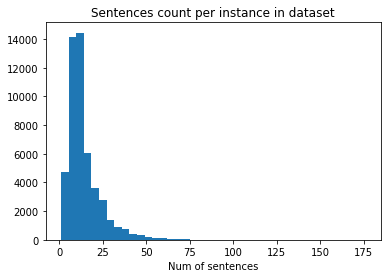

In [34]:
plt.hist(vals, bins=40)
plt.title('Sentences count per instance in dataset')
plt.xlabel("Num of sentences")
plt.show();

Distribution of sentences count across dataset

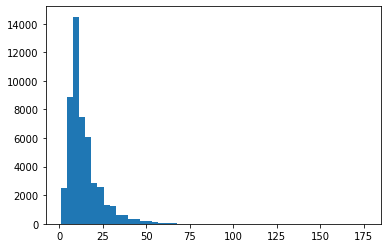

In [35]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=False)
axs.hist(vals, bins=50);

Zoomed on interval 3 to 30

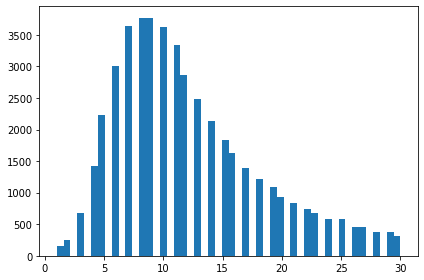

In [36]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(vals, bins=50, range=(1,30));

In [37]:
vals.mean()

14.0104

In [38]:
vals.min()

1

In [39]:
vals.max()

176

In [40]:
len(vals[vals > 7])

38627

**38 627** instances have more than 7 sentences

In [41]:
len(vals[vals >= 10])

31105

**31 105** instances have 10 or more sentences

In [42]:
len(vals[vals >= 40])

1416

In [43]:
len(vals[vals >= 20])

9514

----

In [ ]:
a1 = "Every great once in a while, you stumble upon a movie that exceeds even your wildest expectations. Given the IMDb rating of 4.0, I wasn't really expecting much with The Brotherhood of Satan. I hoped that at a minimum it might be cheesy fun like The Devil's Rain or any of the other early 70s similarly themed Satanic horror films. I couldn't' have been more wrong. What I got instead was an ambitious and intelligent film with a cast I really enjoyed. Speaking in broad terms to avoid giving anything away, the film's style and structure are much more experimental than the straightforward storytelling so prominent in the early 70s. The Brotherhood of Satan doesn't beat you over the head with plot points and explanations. A lot is left to the viewer to fill in the blanks. As a viewer, you know something is amiss, but for the longest period you're just not sure what it is. The unknown helps make for a far creepier atmosphere than most similar films. The ending is effective with its surreal imagery. I sat in amazement as the final credits began to roll. Those wanting a big slam-bang finale will be disappointed with the ending's simplicity. A lesser film would have tried to pull out all the stops and would, most likely, have failed miserably.<br /><br />There are moments in the film where it's easy to forget the director, Bernard McEveety, had primarily worked in television before The Brotherhood of Satan. There are a few scenes that are so well set-up, lit, and shot that even the most accomplished of directors could learn a thing or two. For example, I've seen enough films over the years to realize that directors can sometimes seem to have trouble shooting widescreen shots indoors. Not here. The scene where the men are discussing their plan of action in the sheriff's office is amazing. We see all five men at once \xc2\x96 each doing their own thing as in real life. In a lesser film, we might see all the men at once, but each would be motionless, quietly waiting their turn to deliver their dialogue. It's a small scene, but it looks so natural and is so beautifully shot that it's one of my favorite moments of The Brotherhood of Satan.<br /><br />Finally, I mentioned the acting in my opening, so without going into a long-winded speech, I'll just say that The Brotherhood of Satan features Strother Martin and L.Q. Jones. Any film with these two guys is almost an automatic winner with me."
a2 = "A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss. As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money and extremely tight schedules. Nazarin, however, surpasses many of Bunuel's previous Mexican films in terms of the acting (Francisco Rabal is excellent), narrative and theme.<br /><br />The theme, interestingly, is something that was explored again in Viridiana, made three years later in Spain. It concerns the individual's struggle for humanity and altruism amongst a society that rejects any notion of virtue. Father Nazarin, however, is portrayed more sympathetically than Sister Viridiana. Whereas the latter seems to choose charity because she wishes to atone for her (perceived) sins, Nazarin's whole existence and reason for being seems to be to help others, whether they (or we) like it or not. The film's last scenes, in which he casts doubt on his behaviour and, in a split second, has to choose between the life he has been leading or the conventional life that is expected of a priest, are so emotional because they concern his moral integrity and we are never quite sure whether it remains intact or not.<br /><br />This is a remarkable film and I would urge anyone interested in classic cinema to seek it out. It is one of Bunuel's most moving films, and encapsulates many of his obsessions: frustrated desire, mad love, religious hypocrisy etc. In my view 'Nazarin' is second only to 'The Exterminating Angel', in terms of his Mexican movies, and is certainly near the top of the list of Bunuel's total filmic output."
a3 = "Sure, this one isn\'t really a blockbuster, nor does it target such a position. \"Dieter\" is the first name of a quite popular German musician, who is either loved or hated for his kind of acting and thats exactly what this movie is about. It is based on the autobiography \"Dieter Bohlen\" wrote a few years ago but isn\'t meant to be accurate on that. The movie is filled with some sexual offensive content (at least for American standard) which is either amusing (not for the other \"actors\" of course) or dumb - it depends on your individual kind of humor or on you being a \"Bohlen\"-Fan or not. Technically speaking there isn\'t much to criticize. Speaking of me I find this movie to be an OK-movie."

In [19]:
def preprocess_dataset(dataset, max_sentences_count):
    """
    Counts number of sentences in each instance and filters out those that have less than `max_sentences_count` sentences
    """
    
    def _proc(x, y):
        return x, len(tf.strings.split(x, sep='.')), y
    
    dataset = dataset.map(_proc)
    dataset = dataset.filter(lambda x, y, z: y > max_sentences_count)
    dataset = dataset.map(lambda x, y, z: (x, z))
    
    return dataset

In [20]:
def generate_batches(dataset, num_batches):
    batched = dataset.batch(num_batches)
    for batch in batched.as_numpy_iterator():
        yield batch

In [21]:
def generate_batches_of_size(dataset, size_of_batch):
    seen_instances_count = 0
    while True:
        batch = dataset.skip(seen_instances_count).take(size_of_batch)
        
        if len(list(batch.as_numpy_iterator())) != size_of_batch:
            raise StopIteration("Ran out of data!")
        
        # decode strings to UTF-8
        batch = list(map(lambda x: (x[0].decode('UTF-8'), x[1]), batch.as_numpy_iterator()))
        texts = list(map(lambda x: x[0], batch))
        labels = list(map(lambda x: x[1], batch))
        
        del batch
        seen_instances_count += size_of_batch
        yield (texts, labels)

In [22]:
def generate_sequence(maxN):
    seq = []
    i = 0
    
    while i < maxN:
        seq.append(i)
        i = i + (1 + int(i/10))
    
    return seq

In [26]:
def experiment_pipeline_HP_setup(data, experiment_tag, batch_size=100, to_factor=100, from_sentences_count=10):
    
    l.warning(f'hp experiment - {experiment_tag}')

    start = time.time()
    
    # load model
    model = load_model()
    
    # build summarizer
    summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
    summarizer.stop_words = get_stop_words(LANGUAGE)
    
    # build explanator
    explanator = lime_text.LimeTextExplainer(class_names=CLASSES)
    
    # process data
    data = preprocess_dataset(data, from_sentences_count)
    data_gen = generate_batches_of_size(data, batch_size)
    
    # prepare folder
    try:
        os.makedirs(f'../../data/logs/experiment/{experiment_tag}')
    except FileExistsError as e:
        l.critical(e)

    for fp in generate_sequence(to_factor):
        
        l.info("Started working on factor: " + str(fp))
        
        try:
            data_chunk = next(data_gen)
        except StopIteration as e: # Ran out of data, should not happen
            l.error(e)
            break
        
        # create summaries - both
        csummary = create_explanation_summaries(data_chunk[0], explanator, summarizer, factor=fp)
        ssummary = create_simple_summaries(data_chunk[0], summarizer)
        modelp = model.predict(data_chunk[0])

        csummary_texts = list(map( lambda x: x[SUMMARY_IX], csummary))
        ssummary_texts = list(ssummary)

        mcsummaries = model.predict(csummary_texts)
        mssummaries = model.predict(ssummary_texts)

        l.info("Created summaries for factor: " + str(fp))
        
        assert( all([len(modelp) == len(ssummary), 
                    len(ssummary) == len(csummary),
                    len(csummary_texts) == len(ssummary),
                    len(mssummaries) == len(ssummary_texts)]) )

        # convert true labels
        labels = np.array(list(map(lambda x: [x], data_chunk[1])))
        
        modelp = np.append(modelp, mcsummaries, axis=1)
        modelp = np.append(modelp, mssummaries, axis=1)
        modelp = np.append(modelp, labels, axis=1)
        
        np.savetxt(f'../../data/logs/experiment/{experiment_tag}/fp-{fp}.csv', modelp, fmt='%1.5f', header="originalP,customSP,simpleSP,trueClass")

    # log model prediction on summaries texts
    # log current HP_FACTOR
    end = time.time()
    l.info(f'time taken {end-start}')


In [27]:
experiment_pipeline_HP_setup(data, 'v3-fix', batch_size=100, to_factor=10000, from_sentences_count=19)

KeyboardInterrupt: 

In [ ]:
HP_FACTOR = 5

def experiment_pipeline_imdb(inp, tag, out, iterations=None):
    global HP_FACTOR
    l.info("IMDB quantitative v1" + tag)

    start = time.time()
    
    # read input data
#     inp = input_from_files(INPUT_DIR)
    
    # load model
    model = load_model()
    
    for fp in inp:
        
        # let model create summaries - both
        csummary = create_explanation_summaries(inp, explanator, summarizer)
        ssummary = create_simple_summaries(inp, summarizer)
        modelp = model.predict(list(inp.values()))

        csummary_texts = list(map( lambda x: x[SUMMARY_IX], csummary.values()))
        ssummary_texts = list(ssummary.values())

        mcsummaries = model.predict(csummary_texts)
        mssummaries = model.predict(ssummary_texts)

        l.info("Created summaries for factor: " + str(HP_FACTOR))
        
        assert( all([len(modelp) == len(ssummary), 
                    len(ssummary) == len(csummary),
                    len(csummary_texts) == len(ssummary),
                    len(mssummaries) == len(ssummary_texts)]) )

        modelp = np.append(modelp, mcsummaries, axis=1)
        modelp = np.append(modelp, mssummaries, axis=1)

        np.savetxt(f'../../data/logs/experiment/v2/v2-{fp}.csv', modelp, fmt='%1.5f', header="originalP,customSP,simpleSP")

    # log model prediction on summaries texts
    # log current HP_FACTOR
    end = time.time()
    print(end - start)
    l.info(f'time taken {end-start}')


---

### TODO:
- [x] find a good pytorch/tf LSTM text classification model ~ maybe check datasets in LIME paper
- [x] create predict_proba based on the type of the framework
- [x] allow hyperparameter tuning
- [x] predict on created summaries ~ automatically -> (possible: save summaries to files and then load and pass them just as normal instance) 
- [x] add better logging (more logs in this version)
- [x] build and test quantitative experiment pipeline
- [x] add prediction of model to visualization
- [ ] ~~refactor process to not store everything in RAM, rather put intermediate results to files~~
- [x] highlighting of important words from any summary (maybe save both, str summary and Sentence type summary - from sumy)
- [ ] extract it to separate script ?
- [ ] maybe find better dataset (longer texts) for data and train another model for it
- [ ] run quantitative experiment on all instances
- [ ] pick several (~6) explanations for user-study